# PV Secondary Targeting

Parse a set of PV observations created using the script

`/path/to/timedomain/bin/td_from_program PV > pv_tgt.out`

In [77]:
import os
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)

## Load PV Target ASCII DB

Load the PV secondary targets from an ASCII file.
Then plot the data.

In [15]:
pv_targets = ascii.read('pv_tgt.out', delimiter='|',
                        names=['PROGRAM', 'TARGET_RA', 'TARGET_DEC', 'TARGETID', 'TILEID', 'DATE', 'PETAL'])
pv_targets

PROGRAM,TARGET_RA,TARGET_DEC,TARGETID,TILEID,DATE,PETAL
str14,float64,float64,int64,int64,int64,int64
PV_BRIGHT_HIGH,149.171684545314,2.16060616970239,1070167824007172,13,20210407,3
PV_BRIGHT_HIGH,149.658076810033,0.868788172013763,1070131593609233,14,20210408,1
PV_BRIGHT_HIGH,150.356606634878,3.59611185445412,1070198031384587,14,20210408,5
PV_BRIGHT_HIGH,150.267396959543,3.33093628066686,1070191999975425,14,20210408,5
PV_BRIGHT_HIGH,151.099800148199,2.56094576885652,1070173897359360,14,20210408,7
PV_BRIGHT_HIGH,151.403281837345,1.84924206413151,1070155782160385,14,20210408,8
PV_BRIGHT_HIGH,151.006785108655,1.62447667017721,1070149738168328,14,20210408,9
PV_BRIGHT_HIGH,151.145673966004,1.52285422698331,1070149738168325,14,20210408,9
PV_BRIGHT_HIGH,150.823041569144,1.50048971567638,1070149733974017,14,20210408,9


In [18]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(table['PROGRAM'])
    for class_name in class_names:
        select = table['PROGRAM'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table[select]['TARGET_RA'])
        _dec = np.radians(table[select]['TARGET_DEC'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

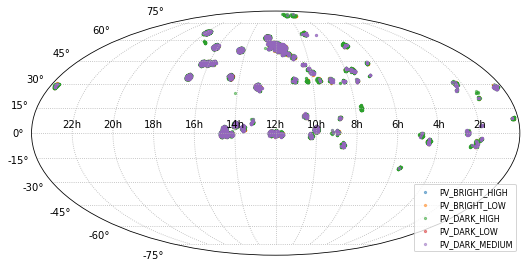

In [19]:
fig = plot_radec(pv_targets)

## Extract Object Redshifts

For each object in the table, extract the redshift. There is an efficient way to do this and a stupid way. Let's get stupid.

In [20]:
tile_date_petal = []

for pv_target in pv_targets:
    tdp = [pv_target[_] for _ in ['TILEID', 'DATE', 'PETAL']]
    if tdp in tile_date_petal:
        continue
    tile_date_petal.append(tdp)

In [90]:
redux = 'daily'

ztable = None

n = 0

for i, (tile, date, petal) in enumerate(tile_date_petal):
    select = (pv_targets['TILEID']==tile) & (pv_targets['DATE']==date) & (pv_targets['PETAL']==petal)
    n += np.sum(select)
    targetids = pv_targets[select]['TARGETID']
    
    zbdir = '{}/{}/tiles/{}/{}'.format(os.environ['DESI_SPECTRO_REDUX'], redux, tile, date)
    zbfile = '{}/zbest-{}-{}-{}.fits'.format(zbdir, petal, tile, date)
    if os.path.exists(zbfile):
        hdus = fits.open(zbfile)
        zbest = hdus['ZBEST'].data
        fmap = hdus['FIBERMAP'].data
        
        # Select matching target IDs from the PV list and the redshift list.
        zselect = np.in1d(zbest['TARGETID'], targetids)
        zbest = zbest[zselect]
        
        # Select matching target IDs from the PV list and fibermap list.
        # The fibermap will contain all exposures for this tile. Just keep the first one.
        fselect = np.in1d(fmap['TARGETID'], targetids)
        fmap = unique(Table(fmap[fselect]), keys='TARGETID', keep='first')
        
        # Join the PV targets with the redshift data and then the fibermap data.
        subtab = join(pv_targets[select]['PROGRAM','TARGETID','DATE','PETAL'], zbest, keys='TARGETID')
        subtab = join(subtab, fmap, keys='TARGETID')
        
        if ztable is None:
            ztable = subtab
        else:
            ztable = vstack([ztable, subtab])
            
#         print(i, n, len(ztable), np.sum(select), np.sum(fselect), np.sum(zselect), zbfile)
#         if np.sum(select) != np.sum(fselect):
#             break
        
        if (i+1) % 100 == 0:
            print('{} out of {}; ({} {})'.format(i+1, len(tile_date_petal), n, len(ztable)))

100 out of 3284; (921 921)
200 out of 3284; (1664 1664)
300 out of 3284; (2652 2652)
400 out of 3284; (3402 3402)
500 out of 3284; (4044 4044)
600 out of 3284; (4696 4696)
700 out of 3284; (5251 5251)
800 out of 3284; (5893 5893)
900 out of 3284; (7040 7040)
1000 out of 3284; (8058 8058)
1100 out of 3284; (8911 8911)
1200 out of 3284; (9721 9721)
1300 out of 3284; (10362 10362)
1400 out of 3284; (10941 10941)
1500 out of 3284; (11516 11516)
1600 out of 3284; (12462 12462)
1700 out of 3284; (13862 13862)
1800 out of 3284; (14355 14355)
1900 out of 3284; (14653 14653)
2000 out of 3284; (15181 15181)
2100 out of 3284; (15529 15529)
2200 out of 3284; (15923 15923)
2300 out of 3284; (16296 16296)
2400 out of 3284; (16562 16562)
2500 out of 3284; (16984 16984)
2600 out of 3284; (17388 17388)
2700 out of 3284; (17875 17875)
2800 out of 3284; (18250 18250)
2900 out of 3284; (18568 18568)
3000 out of 3284; (19032 19032)
3100 out of 3284; (19407 19407)
3200 out of 3284; (19825 19825)


In [94]:
ztable

PROGRAM,TARGETID,DATE,PETAL,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,EXPTIME,PSF_TO_FIBER_SPECFLUX,NIGHT,EXPID,MJD,TILEID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET
str14,int64,int64,int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,int32,int32,str4,float32,float32,float32,float32,float32,float32,int16,int64,str2,float32,float32,float32,float32,str8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,int64,int64,int64,int64,int64,int64,int64,int64
PV_BRIGHT_HIGH,1070167824007172,20210407,3,8.999999999999996e+99,0.0 .. 0.0,-0.0019956912923479522,4.1311493573349107e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1,3,126,3126,1561,520,149.17168454531367,2.1606061697023886,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,218.7591,22.851889,1700,0.08333187011324772,63,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,1700,5,4611686018427387904,0,0,8796093022208,0,0,0,2,218.591,24.332,0.164,-1.497,149.17234133638783,2.16668704929515,363.6893,0.0,20210407,83857,59312.12040935,13,--,--,--,--,--,--,--,--
PV_DARK_HIGH,39627841578469278,20210407,3,17148.387557289563,16209.006182028303 .. 785.5877391604446,0.02054345522768439,8.46910168200425e-06,0,7883,GALAXY,,10,16801.057623653323,0,1,3,422,3422,1608,0,148.5845659928287,2.297555665360112,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,371.95776,58.218826,102100,0.9313062399242229,516,9010,343922,1950,SER,626.78143,1314.678,2223.09,15.280941,5.4766994,2.3428705,4096,1174177,L3,0.0,0.0,0.0,0.0,1486p022,0.046209376,1496.5332,842.5231,0.20871176,0.11013782,77.07959,161.67491,273.38855,77.07959,161.67491,273.38855,3.7954614,5.1538677,-0.01629305,0.4088024,S,102100,9,5764607523034234880,131074,0,79164837199872,0,0,0,2,371.946,58.165,-0.006,0.009,148.58454347463746,2.297519724676011,363.6893,0.7176397801276115,20210407,83857,59312.12040935,13,--,--,--,--,--,--,--,--
PV_DARK_HIGH,39627841578472216,20210407,3,9492.489168858156,2976.9202876603476 .. 194.21012576284306,0.0996967217194942,3.7192873625077817e-05,0,7910,GALAXY,,10,1609.718369731214,0,1,3,359,3359,1994,0,148.72031563724784,2.356287147124274,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,335.72443,72.530365,102100,0.005271210879649324,516,9010,343922,4888,SER,74.09307,181.23122,343.75922,47.865936,21.386744,7.375445,0,3846821410379372928,G2,19.512455,18.819262,17.334963,0.0,1486p022,0.04297064,268.97052,167.8382,0.57354385,0.20062122,12.131433,29.673414,56.284508,12.139204,29.68583,56.301956,6.0,4.5534487,0.21458071,0.077153556,S,102100,9,5764607523034234880,131074,0,79164837199872,0,0,0,2,335.717,72.487,-0.007,0.005,148.72028902389746,2.356266856581495,363.6893,0.7269558059097578,20210407,83857,59312.12040935,13,--,--,--,--,--,--,--,

### Output Redrock Spectral Types

In [95]:
types_, counts_ = np.unique(ztable['SPECTYPE'], return_counts=True)
for t, c in zip(types_, counts_):
    print('{:10s} : {:10d} ({:.1f}%)'.format(t, c, 100*c/len(ztable)))

GALAXY     :      17737 (88.4%)
QSO        :        179 (0.9%)
STAR       :       2149 (10.7%)


## Write Output

### FITS Format

This format is needed to preserve the redrock template coefficients in the output, should they be needed for spectral matching and plotting later.

**WARNING**: the output file will *always* be clobbered so proceed with caution!

In [96]:
ztable.write('pv_redshifts.fits', format='fits', overwrite=True)

### ASCII

Write in ASCII format with a commented header. Necessitates removing the redrock coefficient list from the table first.

**WARNING**: this code is set up to *destructively* alter the table and *always* clobber the output file!

In [97]:
ztable.remove_columns(['COEFF', 'NCOEFF'])
ztable

PROGRAM,TARGETID,DATE,PETAL,CHI2,Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,DELTACHI2,NUMEXP,NUMTILE,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,EXPTIME,PSF_TO_FIBER_SPECFLUX,NIGHT,EXPID,MJD,TILEID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET
str14,int64,int64,int64,float64,float64,float64,int64,int64,str6,str20,float64,int32,int32,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,int32,int32,str4,float32,float32,float32,float32,float32,float32,int16,int64,str2,float32,float32,float32,float32,str8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,int64,int64,int64,int64,int64,int64,int64,int64
PV_BRIGHT_HIGH,1070167824007172,20210407,3,8.999999999999996e+99,-0.0019956912923479522,4.1311493573349107e-48,1570,0,STAR,CV,1.942668892225729e+84,0,1,3,126,3126,1561,520,149.17168454531367,2.1606061697023886,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,218.7591,22.851889,1700,0.08333187011324772,63,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,1700,5,4611686018427387904,0,0,8796093022208,0,0,0,2,218.591,24.332,0.164,-1.497,149.17234133638783,2.16668704929515,363.6893,0.0,20210407,83857,59312.12040935,13,--,--,--,--,--,--,--,--
PV_DARK_HIGH,39627841578469278,20210407,3,17148.387557289563,0.02054345522768439,8.46910168200425e-06,0,7883,GALAXY,,16801.057623653323,0,1,3,422,3422,1608,0,148.5845659928287,2.297555665360112,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,371.95776,58.218826,102100,0.9313062399242229,516,9010,343922,1950,SER,626.78143,1314.678,2223.09,15.280941,5.4766994,2.3428705,4096,1174177,L3,0.0,0.0,0.0,0.0,1486p022,0.046209376,1496.5332,842.5231,0.20871176,0.11013782,77.07959,161.67491,273.38855,77.07959,161.67491,273.38855,3.7954614,5.1538677,-0.01629305,0.4088024,S,102100,9,5764607523034234880,131074,0,79164837199872,0,0,0,2,371.946,58.165,-0.006,0.009,148.58454347463746,2.297519724676011,363.6893,0.7176397801276115,20210407,83857,59312.12040935,13,--,--,--,--,--,--,--,--
PV_DARK_HIGH,39627841578472216,20210407,3,9492.489168858156,0.0996967217194942,3.7192873625077817e-05,0,7910,GALAXY,,1609.718369731214,0,1,3,359,3359,1994,0,148.72031563724784,2.356287147124274,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,335.72443,72.530365,102100,0.005271210879649324,516,9010,343922,4888,SER,74.09307,181.23122,343.75922,47.865936,21.386744,7.375445,0,3846821410379372928,G2,19.512455,18.819262,17.334963,0.0,1486p022,0.04297064,268.97052,167.8382,0.57354385,0.20062122,12.131433,29.673414,56.284508,12.139204,29.68583,56.301956,6.0,4.5534487,0.21458071,0.077153556,S,102100,9,5764607523034234880,131074,0,79164837199872,0,0,0,2,335.717,72.487,-0.007,0.005,148.72028902389746,2.356266856581495,363.6893,0.7269558059097578,20210407,83857,59312.12040935,13,--,--,--,--,--,--,--,--
PV_BRIGHT_LOW,39627841582662355,20210407,3,9089.225879431702,0.09996207424577806,3.568275788984102e-05,0,7906,GALAXY,,2066.681754

In [98]:
ztable.write('pv_redshifts.txt', format='ascii.commented_header', overwrite=True)

In [99]:
len(np.unique(ztable['TARGETID']))

12729

In [109]:
types_, counts_ = np.unique(ztable['PROGRAM'], return_counts=True)
for t, c in zip(types_, counts_):
    print('{:15s} : {:>10d} ({:.1f}%)'.format(t, c, 100*c/len(ztable)))

PV_BRIGHT_HIGH  :       2499 (12.5%)
PV_BRIGHT_LOW   :       2119 (10.6%)
PV_DARK_HIGH    :      11475 (57.2%)
PV_DARK_LOW     :        164 (0.8%)
PV_DARK_MEDIUM  :       3808 (19.0%)
